# Análisis de Imágenes Biomédicas. Práctica 3
## Máster en Bioinformática para las Ciencias de la Salud
### Pedro Sánchez García

In [1]:
from matplotlib import pyplot as plt
import glob
import os
import numpy as np
import cv2
import skimage
from skimage import measure, feature

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imágenes con la región de interés alcanzada en la parte 1:

#### En primer lugar, una vez que se ha llevado a cabo la parte 1 de la práctica,se procede a generar las imágenes resultantes del proceso de segmentación, de forma que se efectúa la aplicación de la máscara correspondiente a la interés alcanzada con la imagen original. Sobre el resultado generado, se llevan a cabo los diferentes procedimientos.

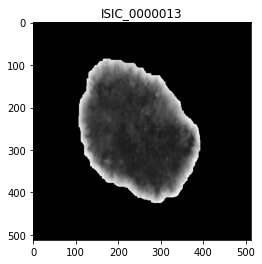

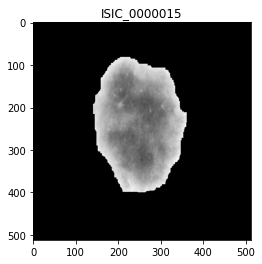

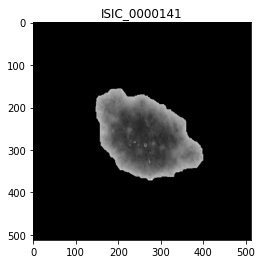

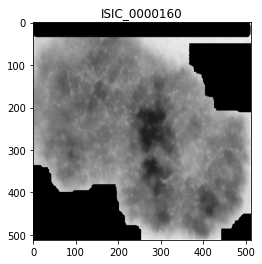

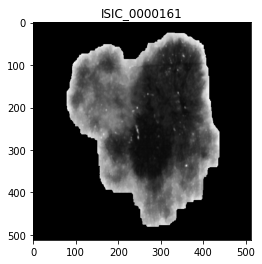

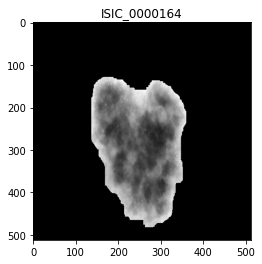

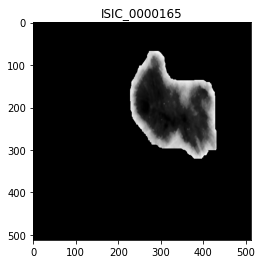

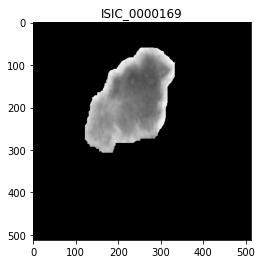

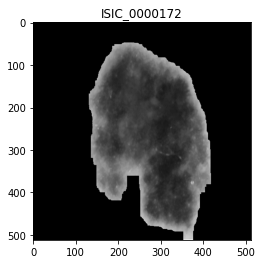

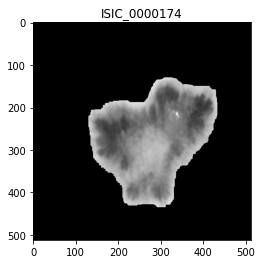

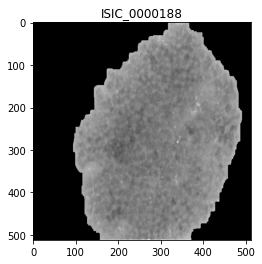

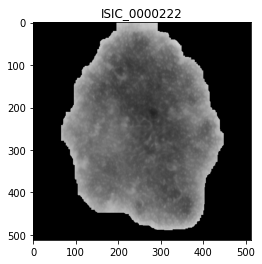

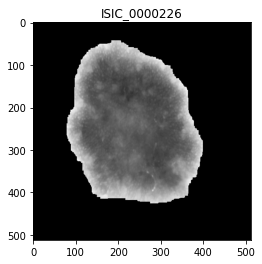

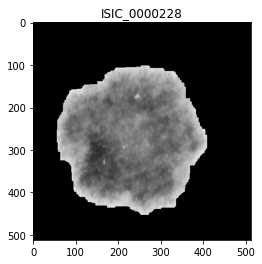

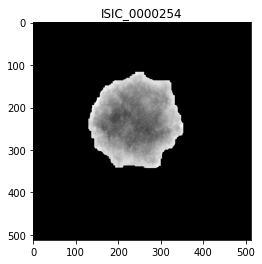

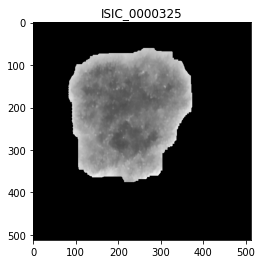

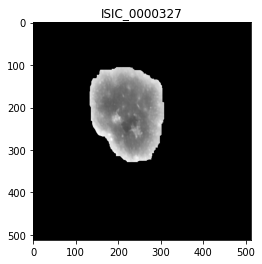

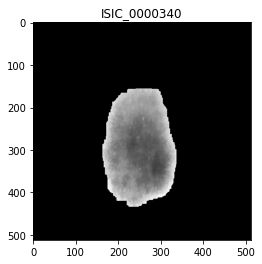

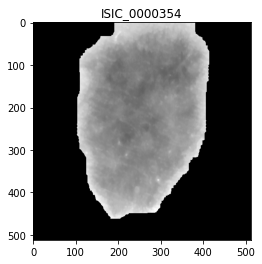

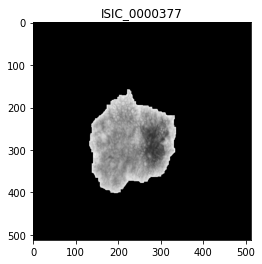

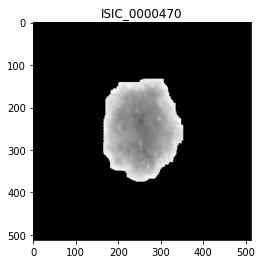

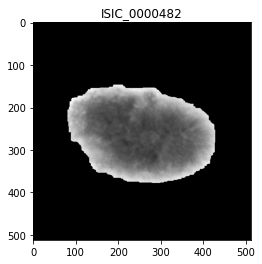

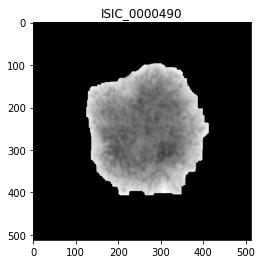

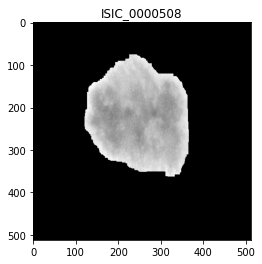

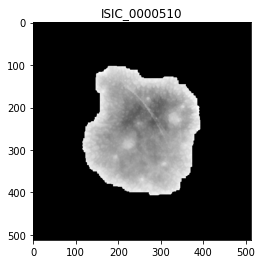

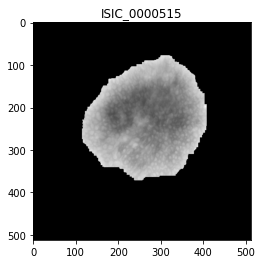

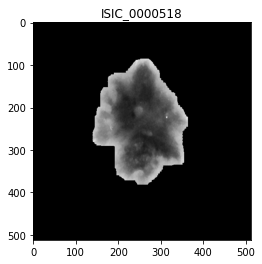

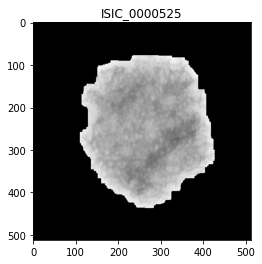

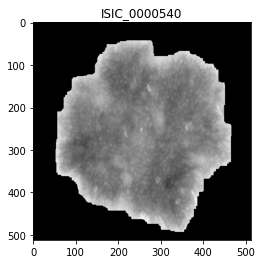

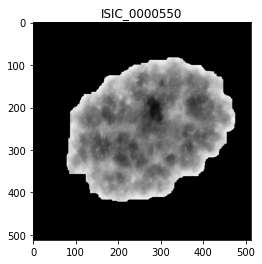

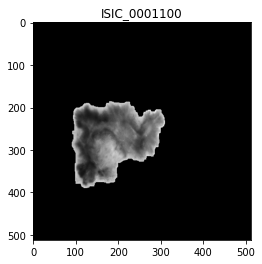

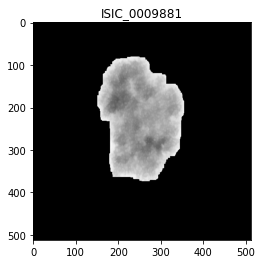

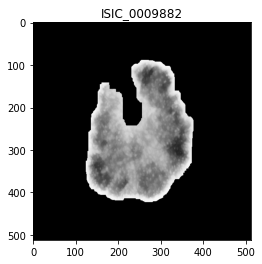

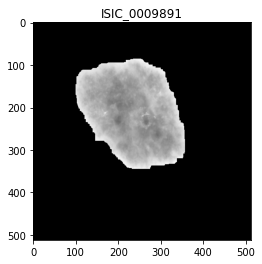

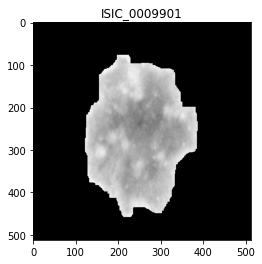

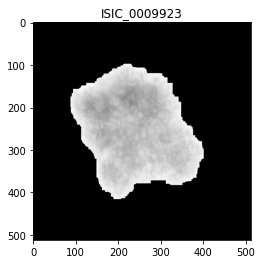

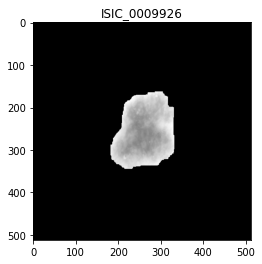

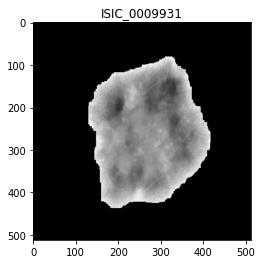

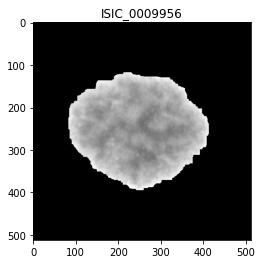

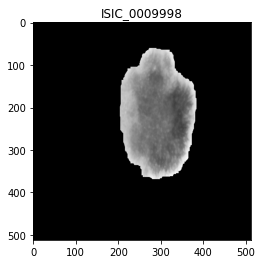

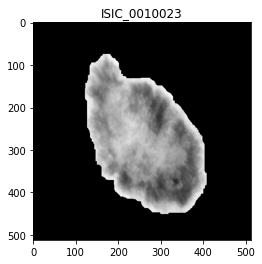

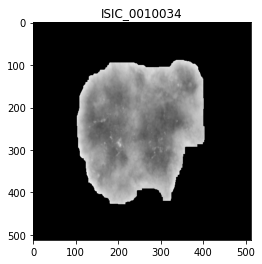

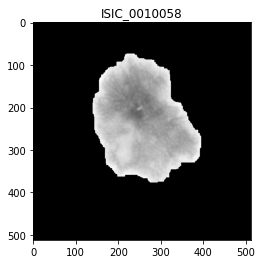

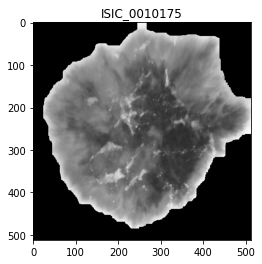

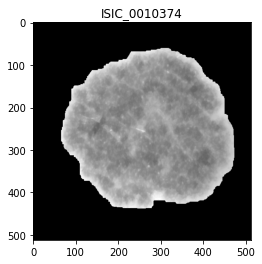

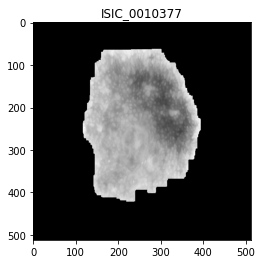

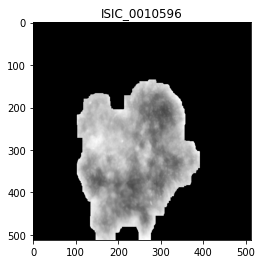

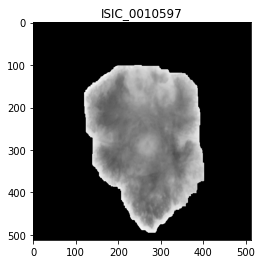

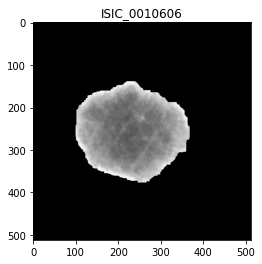

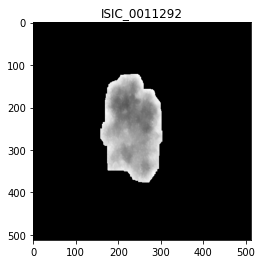

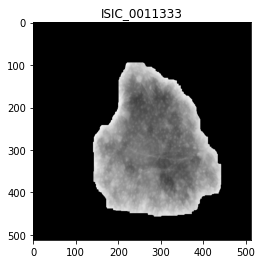

In [ ]:
for im in sorted(glob.glob('/content/drive/MyDrive/Colab Notebooks/dataset/images/*.*')):
     imagen = cv2.imread(im,cv2.IMREAD_GRAYSCALE)
     filename_w_ext = os.path.basename(im) # Nombre completo con extensión
     filename, file_extension = os.path.splitext(filename_w_ext) # División del nombre completo con extensión

     ## Fases de eliminación de pelos basadas en el programa DullRazor:
     kernel = cv2.getStructuringElement(1,(17,17))
     bottomhat = cv2.morphologyEx(imagen, cv2.MORPH_BLACKHAT, kernel)
     ret, threshold = cv2.threshold(bottomhat,10, 255,cv2.THRESH_BINARY)
     final_image = cv2.inpaint(imagen, threshold, 1, cv2.INPAINT_TELEA)
     final_image = cv2.medianBlur(final_image,5)


     ## Segmentación:
    
     thr, dstOTSU = cv2.threshold(final_image,cv2.THRESH_OTSU, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU) 
     thr, dst31 = cv2.threshold(dstOTSU, 100, 255, cv2.THRESH_TOZERO) 
     dst3 = cv2.morphologyEx(dst31, cv2.MORPH_OPEN, np.ones((5,5)))
    
     labels_mask = measure.label(dst3)                       
     regions = measure.regionprops(labels_mask)
     regions.sort(key=lambda x: x.area, reverse=True)
     if len(regions) > 1:
         for rg in regions[1:]:
            labels_mask[rg.coords[:,0], rg.coords[:,1]] = 0
     labels_mask[labels_mask!=0] = 1
     mask = labels_mask
     mask = mask.astype(np.uint8)

     relleno_morph = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
     kernel = np.ones((11,11), np.uint8)
     dilataciones = cv2.dilate(relleno_morph, kernel, iterations=8) # Se determinan 8 iteraciones precisas

     kernel = np.ones((11,11), np.uint8)
     erosiones = cv2.erode(dilataciones, kernel, iterations=5)

     mm = os.path.join("/content/drive/MyDrive/Colab Notebooks/dataset/masks", filename + "_Segmentation.png")
     mask_gt = cv2.imread(mm,cv2.IMREAD_GRAYSCALE)
     erosiones = cv2.resize(erosiones,(512,512))
     mask_gt = cv2.resize(mask_gt,(512,512))

     final_image = cv2.resize(final_image,(512,512))

     producto = final_image * erosiones

     plt.imshow(producto, cmap= 'gray')
     plt.title(filename)
     plt.show()
     
     # Se conservan las correspondientes imágenes:
     #cv2.imwrite('/content/drive/MyDrive/Colab Notebooks/dataset/processed_images/' + filename +'.jpg', producto)


# METODOLOGÍA.

## Tarea 2. Clasificación.

#### Para esta tarea, se centra la atención en diferentes características distintivas de las lesiones cutáneas, que permiten distinguir el melanoma de aquellas lesiones benignas:

##### - **Texturas**: medidas posteriores a la aplicación de filtros de Gabor y matriz de co-ocurrencia.
##### - **Formas**: área, perímetro, diámetro e índice de irregularidad.
##### - **Colores**: media de color en el espacio RGB. 

#### Con respecto al clasificador empleado, se emplea el K-Nearest Neighbors bajo un valor de k=3 en la k-fold dado el reducido tamaño del conjunto. Para evaluar el entrenamiento realizado por cada una de las aproximaciones, se determina el porcentaje de aciertos obtenido en el conjunto de test. De esta forma, tendremos una noción del funcionamiento de nuestro clasificador en un determinado sistema real.

## 2.1 Texturas.

#### Una de las propiedades del melanoma es el incremento en la granularidad superficial frente a lesiones benignas. Por tanto, se plantea una aproximación con la generación de un banco de filtros. Posteriormente, se convoluciona cada imagen con cada uno de los filtros del banco y se calculan estadísticas sobre el resultado de esta convolución (media, varianza y entropía de la imagen convolucionada).

#### El conjunto de estas estadísticas obtenido con todos los filtros conformará el vector de características de la imagen.

### 2.1.1 Lectura de fichero csv proporcionado.

In [3]:
# Lectura del fichero csv proporcionado con los nombres ordenados
# de las imágenes y las correspondientes clases (0 o 1 en función de lesión benigna
# o melanoma respectivamente): 

data = np.loadtxt('/content/drive/MyDrive/Colab Notebooks/dataset/list.csv', 
                    dtype='str', 
                    delimiter = ',')

# Se marca la primera columna: etiquetas correspondientes a las clases.

labels = data[:,0] 

# Se crea un array unidimensional con las etiquetas, que es necesario convertir a bidimensional:

labels = labels.reshape((data.shape[0], 1))
data = data[:,1:] # Las columnas restantes constituyen los vectores de características que se empleen.

# Verificamos las dimensiones correspondientes en cada caso:
print(data.shape, labels.shape)

(51, 1) (51, 1)


### 2.1.2 Creación del banco de filtros.

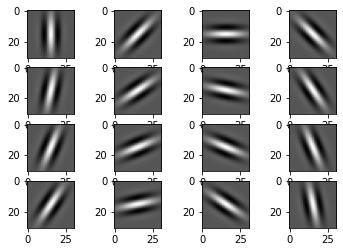

In [4]:
# Se plantea el banco de filtros con los valores de 5.0 para desviación típica de la gaussiana, 11.0 para la longitud de onda de la sinusoidal 
# y de 1.5 para la razón de aspecto espacial:
filters_ejemplo = []
ksize = 31
for theta in np.arange(0, np.pi, np.pi / 16):
    kern = cv2.getGaborKernel((ksize, ksize), 4.0, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F)
    kern /= 1.5*kern.sum()
    filters_ejemplo.append(kern)

f, ax = plt.subplots(4,4)
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(filters_ejemplo[i+j*4], cmap='gray')
plt.show()

### 2.1.3 Convolución de cada imagen con filtros del banco generado.

In [5]:
lista_inicial = []
for im in sorted(glob.glob('/content/drive/MyDrive/Colab Notebooks/dataset/processed_images/*.*')):

    imagen_procesada = cv2.imread(im)
    imagen_procesada = cv2.cvtColor(np.float32(imagen_procesada), cv2.COLOR_BGR2GRAY)
    imagen_procesada = imagen_procesada.astype(float)/255.0 # Normalización de imagen entre 0 y 1
    imagen_procesada = np.array(imagen_procesada)

    filename_w_ext = os.path.basename(im)
    filename, file_extension = os.path.splitext(filename_w_ext)
    feature_vector1 = []
    for index,f in enumerate(filters_ejemplo):
        conv = cv2.filter2D(imagen_procesada, -1, f)
        
        # Se calculan estadísticas para el vector alcanzado:
        mean = np.mean(conv)
        var = np.var(conv)
        feature_vector1.append(mean)
        feature_vector1.append(var)
        
        # Distribucion de colores de la imagen:
        histogram, _ = np.histogram(conv, 100)
        # Probabilidades de ocurrencia de cada color:
        histogram = histogram.astype(float)/ (conv.shape[0]*conv.shape[1])
        # Cálculo de la entropia (cabe destacar que eps es un número flotante notablemente pequeño que se
        # usa para que el logaritmo obtenga valores finitos):
        H = -np.sum(histogram*np.log2(histogram + np.finfo(float).eps))
        feature_vector1.append(H)

    lista_inicial.append(feature_vector1) 

fv1 = np.array(lista_inicial)
print(fv1)

[[0.0491464  0.02604451 2.15706444 ... 0.0491464  0.02497341 2.13986511]
 [0.05512626 0.02394694 1.85282438 ... 0.05512626 0.02308394 1.89832548]
 [0.02757574 0.00938753 1.45050784 ... 0.02757574 0.00970931 1.48611793]
 ...
 [0.0662575  0.03259773 1.6397055  ... 0.0662575  0.03248204 1.68944674]
 [0.04908058 0.04899816 1.23503132 ... 0.04908058 0.04233893 1.27695298]
 [0.09562871 0.04702264 2.41647499 ... 0.09562871 0.04206731 2.5189141 ]]


In [6]:
print(fv1.shape)

(51, 48)


### 2.1.4 Concatenación del fichero csv con el vector de estadísticas determinado.

In [7]:
# Concatenación y comprobación de dimensiones:
concatenación_final = np.column_stack((data,fv1))
print(concatenación_final.shape)

(51, 49)


### 2.1.5 K-Nearest Neighbors.



In [8]:
# Se establecen las etiquetas en el nuevo fichero csv generado:
labels = concatenación_final[:,0]

# Se crea un array unidimensional que es necesario convertir a bidimensional:
labels = labels.reshape((concatenación_final.shape[0], 1)).astype(np.int32)

# Verificación de dimensiones:
print(labels.shape)


(51, 1)


In [9]:
indices = np.arange(0, concatenación_final.shape[0]) # Se marcan todos los indices del vector
np.random.shuffle(indices) # Aleatorización de los indices del vector
print(indices.shape, indices)

k = 3 # k de la k-fold: 3 (debido al reducido tamaño del conjunto)
step = int(concatenación_final.shape[0] / k) # Número de ejemplos usados en cada fold

# De esta forma, en cada iteración de la k-fold seleccionaremos un bloque distinto de
# índices para el conjunto de test y los k-1 restantes para entrenamiento:
# Iteracion 1: T E E E E E E E E E 
# Iteracion 2: E T E E E E E E E E 
# Iteracion 3: E E T E E E E E E E 
# ...
# Iteracion 10: E E E E E E E E E T 

for i in range(k):
    # Indices para test:
    test_idx = indices[i*step:(i+1)*step]
    print(i, "test", test_idx.shape, test_idx)
    
    # Indices para entrenamiento:    
    train_idx_a = indices[:i*step] 
    train_idx_b = indices[(i+1)*step:]
    train_idx = np.concatenate([train_idx_a, train_idx_b])
    print(i, "train", train_idx.shape, train_idx)
    
    # Obtención del conjunto de entrenamiento a partir de los índices:
    train_data_k = concatenación_final[train_idx]
    train_labels_k = labels[train_idx]

    # Obtención del conjunto de test a partir de los índices:
    test_data_k = concatenación_final[test_idx]
    test_labels_k = labels[test_idx]

(51,) [25 31 30 48 36 40 47  3  0 33 41 14 24  1  5  9 38 16 22  4 49 42 29 28
 13 32 12  8 11 10 19  6  7 50 23 39 26  2 46 17 44 20 43 35 21 27 45 15
 18 37 34]
0 test (17,) [25 31 30 48 36 40 47  3  0 33 41 14 24  1  5  9 38]
0 train (34,) [16 22  4 49 42 29 28 13 32 12  8 11 10 19  6  7 50 23 39 26  2 46 17 44
 20 43 35 21 27 45 15 18 37 34]
1 test (17,) [16 22  4 49 42 29 28 13 32 12  8 11 10 19  6  7 50]
1 train (34,) [25 31 30 48 36 40 47  3  0 33 41 14 24  1  5  9 38 23 39 26  2 46 17 44
 20 43 35 21 27 45 15 18 37 34]
2 test (17,) [23 39 26  2 46 17 44 20 43 35 21 27 45 15 18 37 34]
2 train (34,) [25 31 30 48 36 40 47  3  0 33 41 14 24  1  5  9 38 16 22  4 49 42 29 28
 13 32 12  8 11 10 19  6  7 50]


In [10]:
# A continuación, dividimos el conjunto original de entrenamiento en entrenamiento y test:

labels = labels.astype(np.float32) 
concatenación_final = concatenación_final.astype(np.float32) 

train_data = concatenación_final[:34,:]
train_labels = labels[:34,:]
test_data = concatenación_final[-17:,:]
test_labels = labels[-17:,:]

# Se crea el clasificador KNN:
knn = cv2.ml.KNearest_create()

# Posteriormente, se entrna el clasificador:
knn.train(train_data, cv2.ml.ROW_SAMPLE, train_labels)

True

In [11]:
# Se valida el clasificador con el conjunto de test:
ret, results, neighbours, dist = knn.findNearest(test_data, 3)

# Se verifican los resultados para los tres primeros ejemplos del conjunto de test:
for i in range(3):
    print("---- Ejemplo", i, "-----")
    print("Clase seleccionada", results[i])
    print("Vecinos mas proximos", neighbours[i])
    print("Distancia a vecinos", dist[i])
    print("Etiqueta real", test_labels[i])

---- Ejemplo 0 -----
Clase seleccionada [0.]
Vecinos mas proximos [0. 0. 0.]
Distancia a vecinos [0.1032309  0.20791705 0.24374497]
Etiqueta real [0.]
---- Ejemplo 1 -----
Clase seleccionada [0.]
Vecinos mas proximos [0. 0. 0.]
Distancia a vecinos [0.02737776 0.05954664 0.10459482]
Etiqueta real [0.]
---- Ejemplo 2 -----
Clase seleccionada [0.]
Vecinos mas proximos [0. 1. 0.]
Distancia a vecinos [2.0918627 2.6536093 2.8957825]
Etiqueta real [0.]


In [12]:
# Finalmente, se lleva a cabo una comprobación de los resultados en el conjunto de test:
# Aciertos: serán todos los ejemplos en los que el vecino más cercano coincide con la etiqueta establecida.

success = np.sum(results == test_labels)

print("Aciertos", success, "/", test_labels.shape[0], 100*float(success)/float(test_labels.shape[0]), "%")

Aciertos 15 / 17 88.23529411764706 %


## 2.2 Descriptores de formas.

#### Se determina el contorno de las lesiones cutáneas sobre las imágenes que conforman el material de partida en esta parte 2. Posteriormente, se calculan diversos descriptores simples:

##### - `Área`: Comprende el número de píxeles de la lesión cutánea.
##### - `Perímetro`: Se trata del número de píxeles en los bordes de la lesión cutánea.
##### - `Diámetro`: Consiste en la línea que atraviesa el centroide en la lesión cutánea.
##### - `Índice de irregularidad`: $Ir = \dfrac{Perímetro}{Diámetro}$

#### De este modo, se abarcan características de gran relevancia en la distinción de lesiones benignas y melanoma, pues para este último caso, en general hay unos valores superiores en los descriptores mencionados.

### 2.2.1 Determinación del contorno en cada imagen.

In [13]:
lista_inicial2 = []
plt.rcParams["figure.figsize"] = [5,5]
for im in sorted(glob.glob('/content/drive/MyDrive/Colab Notebooks/dataset/processed_images/*.*')):
    imagen_original = cv2.imread(im)
    imagen_procesada = cv2.cvtColor(imagen_original, cv2.COLOR_BGR2GRAY)

    filename_w_ext = os.path.basename(im)
    filename, file_extension = os.path.splitext(filename_w_ext)

    # Se determinan contornos:
    contours, hierarchy = cv2.findContours(imagen_procesada,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

    out = imagen_original * 1 # Se copia la imagen original para no modificarla.
    cv2.drawContours(out, contours, 1, (0,0,255), 2)

    feature_vector2 = []
    for idx, cnt in enumerate(contours):
      # Además, se representa el rectángulo (no rotado) en el que se inscribe el contorno.
      # Por tanto, x e y representan la esquina superior izquierda.
      # Además, w y h es el ancho y alto del rectángulo.
      x,y,w,h = cv2.boundingRect(cnt) 
      Diámetro = w
      Área = cv2.contourArea(cnt)
      Perímetro = cv2.arcLength(cnt, True)
      Irregularidad = Perímetro/Diámetro

    # Se añaden los resultados alcanzados para cada medida:
    feature_vector2.append(Diámetro)
    feature_vector2.append(Área)
    feature_vector2.append(Perímetro)
    feature_vector2.append(Irregularidad)
    lista_inicial2.append(feature_vector2) 

# Finalmente, se genera este nuevo vector de características descriptivas de formas:
fv2 = np.array(lista_inicial2)
print(fv2.shape)

(51, 4)


### 2.2.2 Concatenación del fichero csv con el vector de estadísticas determinado.

In [14]:
# Concatenación final y verificación de las dimensiones:
concatenación_final2 = np.column_stack((data,fv2))
print(concatenación_final2.shape)

(51, 5)


### 2.2.3 K-Nearest Neighbors.

In [15]:
# Se establecen las etiquetas en el nuevo fichero csv generado:
labels = concatenación_final2[:,0]

# Se crea un array unidimensional que es necesario convertir a bidimensional:
labels = labels.reshape((concatenación_final2.shape[0], 1)).astype(np.int32)

# Verificación de dimensiones:
print(labels.shape)

(51, 1)


In [16]:
indices = np.arange(0, concatenación_final2.shape[0]) # Se marcan todos los indices del vector
np.random.shuffle(indices) # Aleatorización de los indices del vector
print(indices.shape, indices)

k = 3 # k de la k-fold: 3 (debido al reducido tamaño del conjunto)
step = int(concatenación_final2.shape[0] / k) # Número de ejemplos usados en cada fold

# De esta forma, en cada iteración de la k-fold seleccionaremos un bloque distinto de
# índices para el conjunto de test y los k-1 restantes para entrenamiento:
# Iteracion 1: T E E E E E E E E E 
# Iteracion 2: E T E E E E E E E E 
# Iteracion 3: E E T E E E E E E E 
# ...
# Iteracion 10: E E E E E E E E E T 

for i in range(k):
    # Indices para test:
    test_idx = indices[i*step:(i+1)*step]
    print(i, "test", test_idx.shape, test_idx)
    
    # Indices para entrenamiento:    
    train_idx_a = indices[:i*step] 
    train_idx_b = indices[(i+1)*step:]
    train_idx = np.concatenate([train_idx_a, train_idx_b])
    print(i, "train", train_idx.shape, train_idx)
    
    # Obtención del conjunto de entrenamiento a partir de los índices:
    train_data_k = concatenación_final2[train_idx]
    train_labels_k = labels[train_idx]

    # Obtención del conjunto de test a partir de los índices:
    test_data_k = concatenación_final2[test_idx]
    test_labels_k = labels[test_idx]

(51,) [ 3 14 20 22 39  6 38  0 49 45  7 12 15 21 44  4 23 48 10 35 30 37 32 47
 16  2  5 24 27 31 43 50 18 19 28 34  1 17 42 36 25  9 33 40 46 41 11  8
 29 13 26]
0 test (17,) [ 3 14 20 22 39  6 38  0 49 45  7 12 15 21 44  4 23]
0 train (34,) [48 10 35 30 37 32 47 16  2  5 24 27 31 43 50 18 19 28 34  1 17 42 36 25
  9 33 40 46 41 11  8 29 13 26]
1 test (17,) [48 10 35 30 37 32 47 16  2  5 24 27 31 43 50 18 19]
1 train (34,) [ 3 14 20 22 39  6 38  0 49 45  7 12 15 21 44  4 23 28 34  1 17 42 36 25
  9 33 40 46 41 11  8 29 13 26]
2 test (17,) [28 34  1 17 42 36 25  9 33 40 46 41 11  8 29 13 26]
2 train (34,) [ 3 14 20 22 39  6 38  0 49 45  7 12 15 21 44  4 23 48 10 35 30 37 32 47
 16  2  5 24 27 31 43 50 18 19]


In [17]:
# División del conjunto original de entrenamiento en entrenamiento y test:

labels = labels.astype(np.float32) 
concatenación_final2 = concatenación_final2.astype(np.float32) 

train_data = concatenación_final2[:34,:]
train_labels = labels[:34,:]
test_data = concatenación_final2[-17:,:]
test_labels = labels[-17:,:]

# Creación del clasificador KNN:
knn = cv2.ml.KNearest_create()

# Entrenamiento del clasificador KNN:
knn.train(train_data, cv2.ml.ROW_SAMPLE, train_labels)

True

In [18]:
# Validación del clasificador con el conjunto de test:
ret, results, neighbours, dist = knn.findNearest(test_data, 3)

# Comprobamos los resultados para los tres primeros ejemplos del conjunto de test:
for i in range(3):
    print("---- Ejemplo", i, "-----")
    print("Clase seleccionada", results[i])
    print("Vecinos mas proximos", neighbours[i])
    print("Distancia a vecinos", dist[i])
    print("Etiqueta real", test_labels[i])

---- Ejemplo 0 -----
Clase seleccionada [0.]
Vecinos mas proximos [0. 0. 1.]
Distancia a vecinos [  8.433706 291.78403  359.05804 ]
Etiqueta real [0.]
---- Ejemplo 1 -----
Clase seleccionada [1.]
Vecinos mas proximos [0. 1. 1.]
Distancia a vecinos [0. 1. 1.]
Etiqueta real [0.]
---- Ejemplo 2 -----
Clase seleccionada [0.]
Vecinos mas proximos [0. 1. 0.]
Distancia a vecinos [1.02334904e+08 1.81895616e+08 2.16745408e+08]
Etiqueta real [0.]


In [19]:
# Finalmente, se lleva a cabo una comprobación de los resultados en el conjunto de test:
# Aciertos: serán todos los ejemplos en los que el vecino más cercano coincide con la etiqueta establecida.

success = np.sum(results == test_labels)

print("Aciertos", success, "/", test_labels.shape[0], 100*float(success)/float(test_labels.shape[0]), "%")

Aciertos 10 / 17 58.8235294117647 %


#### En base a los resultados alcanzados, se centra la atención de nuevo en propiedades de texturas, en concreto, para la matriz de co-ocurrencia. 

## 2.3 Texturas (matrices de co-ocurrencia).

#### Una característica que se emplea comúnmente en clasificación y que se relaciona con texturas, es la matriz de co-ocurrencia. Se procede a su planteamiento con pares de píxeles situados a una distancia 1 y 9 y con ángulos de 0, 45, 90 y 135 grados. 

#### Posteriormente, se calculan diferentes propiedades:
##### - `contraste`: $\sum_{i,j=0}^{256} P(i,j)(i-j)^2$
##### - `energía`: $\sqrt{ASM}$
##### - `correlación`:$\sum_{i,j=0}^{256} P(i,j) \dfrac{(i-\mu_i)(j-\mu_j)}{\sqrt{\sigma_i^2\sigma_j^2}}$
##### - `homogeneidad`: $\sum_{i,j=0}^{256} \dfrac{P(i,j)}{1+(i-j)^2}$

In [20]:
from skimage.feature import greycomatrix, greycoprops

### 2.3.1 Determinación de propiedades en la matriz de co-ocurrencia.

In [21]:
# Se procede al cálculo de la matriz de co-ocurrencia con pares de píxeles situados
# a una distancia 1 y 9 y con ángulos de 0, 45, 90 y 135 grados:

lista_inicial3 = []
plt.rcParams["figure.figsize"] = [5,5]
for im in sorted(glob.glob('/content/drive/MyDrive/Colab Notebooks/dataset/processed_images/*.*')):
    imagen_original = cv2.imread(im)
    imagen_procesada = cv2.cvtColor(imagen_original, cv2.COLOR_BGR2GRAY)

    filename_w_ext = os.path.basename(im)
    filename, file_extension = os.path.splitext(filename_w_ext)

    cm = greycomatrix(imagen_procesada, [1, 9], [0, np.pi/4, np.pi/2, 3*np.pi/4], normed=True, symmetric=True)
    
    feature_vector3 = []
    
    # Se calculan las siguientes propiedades: contraste, energía, correlación y homogeneidad:
    contraste = greycoprops(cm, 'contrast') 
    feature_vector_contraste = np.reshape(contraste, (1, contraste.shape[0]*contraste.shape[1]))
    media_contraste = np.mean(feature_vector_contraste)

    energía = greycoprops(cm, 'energy')
    feature_vector_energy = np.reshape(energía, (1, energía.shape[0]*energía.shape[1])) 
    media_energía = np.mean(feature_vector_energy)

    correlación = greycoprops(cm, 'correlation')
    feature_vector_correlación = np.reshape(correlación, (1, correlación.shape[0]*correlación.shape[1])) 
    media_correlación = np.mean(feature_vector_correlación)

    homogeneidad = greycoprops(cm, 'homogeneity')
    feature_vector_homogeneidad = np.reshape(homogeneidad, (1, homogeneidad.shape[0]*homogeneidad.shape[1])) 
    media_homogeneidad = np.mean(feature_vector_homogeneidad)

    # Se añaden los resultados alcanzados:
    feature_vector3.append(media_contraste)
    feature_vector3.append(media_energía)
    feature_vector3.append(media_correlación)
    feature_vector3.append(media_homogeneidad)
    lista_inicial3.append(feature_vector3) 

# Este nuevo vector de características consta de las propiedades calculadas:
fv3 = np.array(lista_inicial3)
print(fv3.shape)

(51, 4)


### 2.3.2 Concatenación del fichero csv con el vector de estadísticas determinado.

In [22]:
# Concatenación con fichero csv original:
concatenación_final3 = np.column_stack((data,fv3))
print(concatenación_final3.shape)

(51, 5)


### 2.3.3 K-Nearest Neighbors.

In [23]:
labels = concatenación_final3[:,0]

# Se crea un array unidimensional que es necesario convertir a bidimensional:
labels = labels.reshape((concatenación_final3.shape[0], 1)).astype(np.int32)

# Verificación de dimensiones:
print(labels.shape)

(51, 1)


In [24]:
indices = np.arange(0, concatenación_final3.shape[0]) # Totalidad de indices del vector
np.random.shuffle(indices) # Aleatorización de los indices del vector
print(indices.shape, indices)

k = 3 # k de la k-fold 
step = int(concatenación_final3.shape[0] / k) # Número de ejemplos usados en cada fold

# De esta forma, en cada iteración de la k-fold seleccionaremos un bloque distinto de
# índices para el conjunto de test y los k-1 restantes para entrenamiento:
# Iteracion 1: T E E E E E E E E E 
# Iteracion 2: E T E E E E E E E E 
# Iteracion 3: E E T E E E E E E E 
# ...
# Iteracion 10: E E E E E E E E E T 

for i in range(k):
    # Indices para test:
    test_idx = indices[i*step:(i+1)*step]
    print(i, "test", test_idx.shape, test_idx)
    
    # Indices para entrenamiento:    
    train_idx_a = indices[:i*step] 
    train_idx_b = indices[(i+1)*step:]
    train_idx = np.concatenate([train_idx_a, train_idx_b])
    print(i, "train", train_idx.shape, train_idx)
    
    # Obtención del conjunto de entrenamiento a partir de los índices:
    train_data_k = concatenación_final3[train_idx]
    train_labels_k = labels[train_idx]

    # Obtención del conjunto de test a partir de los índices:
    test_data_k = concatenación_final3[test_idx]
    test_labels_k = labels[test_idx]

(51,) [38 20 42 29 21  5  9 34 13 27 35 15  0  4 44  8 41 24 23 43 26 32  1 31
 12  7 28 39 19 37 14 16 33 18 17 25  6 47 49 50 10 48 11 45 22 40 30  3
 46 36  2]
0 test (17,) [38 20 42 29 21  5  9 34 13 27 35 15  0  4 44  8 41]
0 train (34,) [24 23 43 26 32  1 31 12  7 28 39 19 37 14 16 33 18 17 25  6 47 49 50 10
 48 11 45 22 40 30  3 46 36  2]
1 test (17,) [24 23 43 26 32  1 31 12  7 28 39 19 37 14 16 33 18]
1 train (34,) [38 20 42 29 21  5  9 34 13 27 35 15  0  4 44  8 41 17 25  6 47 49 50 10
 48 11 45 22 40 30  3 46 36  2]
2 test (17,) [17 25  6 47 49 50 10 48 11 45 22 40 30  3 46 36  2]
2 train (34,) [38 20 42 29 21  5  9 34 13 27 35 15  0  4 44  8 41 24 23 43 26 32  1 31
 12  7 28 39 19 37 14 16 33 18]


In [25]:
# División del conjunto original de entrenamiento en entrenamiento y test:

labels = labels.astype(np.float32) 
concatenación_final3 = concatenación_final3.astype(np.float32) 

train_data = concatenación_final3[:34,:]
train_labels = labels[:34,:]
test_data = concatenación_final3[-17:,:]
test_labels = labels[-17:,:]

# Se plantea el clasificador KNN:
knn = cv2.ml.KNearest_create()

# Entrenamiento posterior del clasificador:
knn.train(train_data, cv2.ml.ROW_SAMPLE, train_labels)

True

In [26]:
# Validamos el clasificador con el conjunto de test:
ret, results, neighbours, dist = knn.findNearest(test_data, 3)

# Verificación de resultados para los tres primeros ejemplos del conjunto de test:
for i in range(3):
    print("---- Ejemplo", i, "-----")
    print("Clase seleccionada", results[i])
    print("Vecinos mas proximos", neighbours[i])
    print("Distancia a vecinos", dist[i])
    print("Etiqueta real", test_labels[i])

---- Ejemplo 0 -----
Clase seleccionada [1.]
Vecinos mas proximos [1. 1. 1.]
Distancia a vecinos [  3.8830395   6.860722  107.43333  ]
Etiqueta real [0.]
---- Ejemplo 1 -----
Clase seleccionada [1.]
Vecinos mas proximos [1. 1. 1.]
Distancia a vecinos [ 2.5733805  9.253105  84.554474 ]
Etiqueta real [0.]
---- Ejemplo 2 -----
Clase seleccionada [0.]
Vecinos mas proximos [1. 0. 0.]
Distancia a vecinos [214.85837 246.6584  774.68445]
Etiqueta real [0.]


In [27]:
# Finalmente, se lleva a cabo una comprobación de los resultados en el conjunto de test:
# Aciertos: serán todos los ejemplos en los que el vecino más cercano coincide con la etiqueta establecida.
success = np.sum(results == test_labels)

print("Aciertos", success, "/", test_labels.shape[0], 100*float(success)/float(test_labels.shape[0]), "%")

Aciertos 7 / 17 41.1764705882353 %


## 2.4 Colores:

#### La evaluación de colores como una medida para la clasificación de lesiones cutáneas se emplea con frecuencia. El motivo es que para el melanoma no se produce una variación en torno a la uniformidad de colores, debido a que el marrón y negro son predominantes. En el presente trabajo, se opta por determinar la media en los valores de colores para el espacio RGB. 

### 2.4.1 Determinación de la media de color en espacio RGB.

In [28]:
lista_colores = []
for im in sorted(glob.glob('/content/drive/MyDrive/Colab Notebooks/dataset/processed_images/*.*')):
    imagen_original = cv2.imread(im)
    imagen = cv2.cvtColor(imagen_original, cv2.COLOR_BGR2RGB)

    filename_w_ext = os.path.basename(im)
    filename, file_extension = os.path.splitext(filename_w_ext)

    media_color = np.mean(imagen)

    lista_colores.append(media_color)

# Este nuevo vector de características consta de la media de color en RGB:
fv_colores = np.array(lista_colores)
print(fv_colores)

[18.79850006 21.08579636 10.54772186 97.47605896 31.75314331 20.62662888
  9.72030258 12.33702087 29.55211639 29.98643875 76.94293594 56.60873413
 30.34811401 41.13459396 13.16761017 34.93339157 13.27998734 15.5257988
 58.33660126 14.18801117 16.23218918 19.3548851  19.59357071 31.27012634
 31.98886108 24.34332275 11.38543701 38.86484528 50.47047424 37.15431213
  7.62715912 21.85369492 25.11681747 22.44130325 41.01171875 40.56058121
 13.08760834 31.57198715 34.29648209 20.67137146 33.0205574  30.51893234
 24.06888962 60.83623123 64.75672913 34.21895981 35.09832382 37.25722122
 25.34349442 18.77332306 36.57798386]


### 2.4.2 Concatenación del fichero csv con el vector de estadísticas determinado.

In [29]:
# Se lleva a cabo la concatenación y comprobación de dimensiones:
concatenación_colores = np.column_stack((data,fv_colores))
print(concatenación_colores.shape)

(51, 2)


### 2.4.3 K-Nearest Neighbors.

In [30]:
# Se establecen las etoquetas en el conjunto generado:
labels = concatenación_colores[:,0]

# Se crea un array unidimensional que es necesario convertir a bidimensional:
labels = labels.reshape((concatenación_colores.shape[0], 1)).astype(np.int32)

# Verificación de dimensiones:
print(labels.shape)

(51, 1)


In [31]:
indices = np.arange(0, concatenación_colores.shape[0]) # Totalidad de indices del vector
np.random.shuffle(indices) # Aleatorización de los indices del vector
print(indices.shape, indices)

k = 3 # k de la k-fold 
step = int(concatenación_colores.shape[0] / k) # Número de ejemplos usados en cada fold

# De esta forma, en cada iteración de la k-fold seleccionaremos un bloque distinto de
# índices para el conjunto de test y los k-1 restantes para entrenamiento:
# Iteracion 1: T E E E E E E E E E 
# Iteracion 2: E T E E E E E E E E 
# Iteracion 3: E E T E E E E E E E 
# ...
# Iteracion 10: E E E E E E E E E T 

for i in range(k):
    # Indices para test:
    test_idx = indices[i*step:(i+1)*step]
    print(i, "test", test_idx.shape, test_idx)
    
    # Indices para entrenamiento:    
    train_idx_a = indices[:i*step] 
    train_idx_b = indices[(i+1)*step:]
    train_idx = np.concatenate([train_idx_a, train_idx_b])
    print(i, "train", train_idx.shape, train_idx)
    
    # Obtención del conjunto de entrenamiento a partir de los índices:
    train_data_k = concatenación_colores[train_idx]
    train_labels_k = labels[train_idx]

    # Obtención del conjunto de test a partir de los índices:
    test_data_k = concatenación_colores[test_idx]
    test_labels_k = labels[test_idx]

(51,) [10 40 16 38 22 26  3 28 45 29  7 43  6  1 14 37  5  0 27 32 30  9 46 17
 12 18 48 50 33 41 20  2 13 35 36 31  8 11 19 25 42 34 15 44 24 47 23 21
 39  4 49]
0 test (17,) [10 40 16 38 22 26  3 28 45 29  7 43  6  1 14 37  5]
0 train (34,) [ 0 27 32 30  9 46 17 12 18 48 50 33 41 20  2 13 35 36 31  8 11 19 25 42
 34 15 44 24 47 23 21 39  4 49]
1 test (17,) [ 0 27 32 30  9 46 17 12 18 48 50 33 41 20  2 13 35]
1 train (34,) [10 40 16 38 22 26  3 28 45 29  7 43  6  1 14 37  5 36 31  8 11 19 25 42
 34 15 44 24 47 23 21 39  4 49]
2 test (17,) [36 31  8 11 19 25 42 34 15 44 24 47 23 21 39  4 49]
2 train (34,) [10 40 16 38 22 26  3 28 45 29  7 43  6  1 14 37  5  0 27 32 30  9 46 17
 12 18 48 50 33 41 20  2 13 35]


In [32]:
# Se divide el conjunto original de entrenamiento en entrenamiento y test:

labels = labels.astype(np.float32) 
concatenación_colores = concatenación_colores.astype(np.float32) 

train_data = concatenación_colores[:34,:]
train_labels = labels[:34,:]
test_data = concatenación_colores[-17:,:]
test_labels = labels[-17:,:]

# Se plantea el clasificador KNN:
knn = cv2.ml.KNearest_create()
# Entrenamiento final del clasificador KNN:
knn.train(train_data, cv2.ml.ROW_SAMPLE, train_labels)

True

In [33]:
# Validación del clasificador con el conjunto de test:
ret, results, neighbours, dist = knn.findNearest(test_data, 3)

# Comprobación de resultados para los tres primeros ejemplos del conjunto de test:
for i in range(3):
    print("---- Ejemplo", i, "-----")
    print("Clase seleccionada", results[i])
    print("Vecinos mas proximos", neighbours[i])
    print("Distancia a vecinos", dist[i])
    print("Etiqueta real", test_labels[i])

---- Ejemplo 0 -----
Clase seleccionada [0.]
Vecinos mas proximos [1. 0. 0.]
Distancia a vecinos [ 1.0150983  4.6090655 14.879586 ]
Etiqueta real [0.]
---- Ejemplo 1 -----
Clase seleccionada [0.]
Vecinos mas proximos [1. 0. 0.]
Distancia a vecinos [ 1.3294907  2.8755205 11.602669 ]
Etiqueta real [0.]
---- Ejemplo 2 -----
Clase seleccionada [1.]
Vecinos mas proximos [1. 1. 0.]
Distancia a vecinos [1.0064003 1.0370097 1.2108864]
Etiqueta real [0.]


In [34]:
# Finalmente, se lleva a cabo una comprobación de los resultados en el conjunto de test:
# Aciertos: serán todos los ejemplos en los que el vecino más cercano coincide con la etiqueta establecida.
success = np.sum(results == test_labels)

print("Aciertos", success, "/", test_labels.shape[0], 100*float(success)/float(test_labels.shape[0]), "%")

Aciertos 10 / 17 58.8235294117647 %


## 2.5 Combinación de características.

### 2.5.1 Colores y descriptores de formas. 

In [38]:
lista_combina = []
for im in sorted(glob.glob('/content/drive/MyDrive/Colab Notebooks/dataset/processed_images/*.*')):
    imagen_original = cv2.imread(im)
    imagen = cv2.cvtColor(imagen_original, cv2.COLOR_BGR2GRAY)

    # Contornos:
    contours, hierarchy = cv2.findContours(imagen,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    out = imagen * 1 # Se copia la imagen original para no modificarla
    cv2.drawContours(out, contours, 1, (0,0,255), 2)

    filename_w_ext = os.path.basename(im)
    filename, file_extension = os.path.splitext(filename_w_ext)

    feature_vector_combina = []
    for idx, cnt in enumerate(contours):
      # Representación del rectángulo (no rotado) en el que se inscribe el contorno
      # x,y representan la esquina superior izquierda 
      # w,h es el ancho y alto del rectángulo
      x,y,w,h = cv2.boundingRect(cnt) 
      Diámetro = w
      Área = cv2.contourArea(cnt)
      Perímetro = cv2.arcLength(cnt, True)
      Irregularidad = Perímetro/Diámetro

    # Determinación de medidas correspondientes a descriptores de formas:
    feature_vector_combina.append(Diámetro)
    feature_vector_combina.append(Área)
    feature_vector_combina.append(Perímetro)
    feature_vector_combina.append(Irregularidad)

    media_color = np.mean(imagen)
    feature_vector_combina.append(media_color)
    combinación = lista_combina.append(feature_vector_combina)

# Este nuevo vector de características consta de la media de color en RGB y de las medidas determinadas para formas:
fv_combina = np.array(lista_combina)
print(fv_combina.shape)

(51, 5)


#### 2.5.1.1 Concatenación de fichero csv original con vector de características alcanzado.

In [39]:
# Concatenación combinación:
concatenación_combina = np.column_stack((data,fv_combina))
print(concatenación_combina.shape)

(51, 6)


#### 2.5.1.2 K-Nearest Neighbors.

In [40]:
# Se establecen las etiquetas del conjunto generado:
labels = concatenación_combina[:,0]

# Se crea un array unidimensional que es necesario convertir a bidimensional:
labels = labels.reshape((concatenación_combina.shape[0], 1)).astype(np.int32)

# Verificación de dimensiones:
print(labels.shape)

(51, 1)


In [41]:
indices = np.arange(0, concatenación_combina.shape[0]) # Todos los indices del vector
np.random.shuffle(indices) # Aleatorizar los indices del vector
print(indices.shape, indices)

k = 3 # k de la k-fold 
step = int(concatenación_combina.shape[0] / k) # Numero de ejemplos usados en cada fold

# En cada iteracion de la k-fold seleccionaremos un bloque distinto de
# indices para el conjunto de test y los k-1 restantes para 
# entrenamiento:
# Iteracion 1: T E E E E E E E E E 
# Iteracion 2: E T E E E E E E E E 
# Iteracion 3: E E T E E E E E E E 
# ...
# Iteracion 10: E E E E E E E E E T 

for i in range(k):
    # Indices para test:
    test_idx = indices[i*step:(i+1)*step]
    print(i, "test", test_idx.shape, test_idx)
    
    # Indices para entrenamiento:    
    train_idx_a = indices[:i*step] 
    train_idx_b = indices[(i+1)*step:]
    train_idx = np.concatenate([train_idx_a, train_idx_b])
    print(i, "train", train_idx.shape, train_idx)
    
    # Obtener el conjunto de entrenamiento a partir de los índices:
    train_data_k = concatenación_combina[train_idx]
    train_labels_k = labels[train_idx]

    # Obtener el conjunto de test a partir de los índices:
    test_data_k = concatenación_combina[test_idx]
    test_labels_k = labels[test_idx]

(51,) [44 42 50 29 33 35 13 36 28 49  8  7 15 26  0  3 14 19 24  4 23 20 45  6
 41 12 18 22  5 46 32 11 47 39 25 16 37  1 21 40 43  9 48 27 17  2 10 31
 38 30 34]
0 test (17,) [44 42 50 29 33 35 13 36 28 49  8  7 15 26  0  3 14]
0 train (34,) [19 24  4 23 20 45  6 41 12 18 22  5 46 32 11 47 39 25 16 37  1 21 40 43
  9 48 27 17  2 10 31 38 30 34]
1 test (17,) [19 24  4 23 20 45  6 41 12 18 22  5 46 32 11 47 39]
1 train (34,) [44 42 50 29 33 35 13 36 28 49  8  7 15 26  0  3 14 25 16 37  1 21 40 43
  9 48 27 17  2 10 31 38 30 34]
2 test (17,) [25 16 37  1 21 40 43  9 48 27 17  2 10 31 38 30 34]
2 train (34,) [44 42 50 29 33 35 13 36 28 49  8  7 15 26  0  3 14 19 24  4 23 20 45  6
 41 12 18 22  5 46 32 11 47 39]


In [42]:
# Dividimos el conjunto original de entrenamiento en entrenamiento y test:

labels = labels.astype(np.float32) 
concatenación_combina = concatenación_combina.astype(np.float32) 

train_data = concatenación_combina[:34,:]
train_labels = labels[:34,:]
test_data = concatenación_combina[-17:,:]
test_labels = labels[-17:,:]

# Se genera el clasificador KNN:
knn = cv2.ml.KNearest_create()

# Entrenamiento del clasificador KNN:
knn.train(train_data, cv2.ml.ROW_SAMPLE, train_labels)

True

In [43]:
# Validamos el clasificador con el conjunto de test:
ret, results, neighbours, dist = knn.findNearest(test_data, 3)

# Comprobamos resultados para los tres primeros ejemplos del conjunto de test:
for i in range(3):
    print("---- Ejemplo", i, "-----")
    print("Clase seleccionada", results[i])
    print("Vecinos mas proximos", neighbours[i])
    print("Distancia a vecinos", dist[i])
    print("Etiqueta real", test_labels[i])

---- Ejemplo 0 -----
Clase seleccionada [0.]
Vecinos mas proximos [0. 0. 1.]
Distancia a vecinos [ 13.042772 455.7863   803.76306 ]
Etiqueta real [0.]
---- Ejemplo 1 -----
Clase seleccionada [1.]
Vecinos mas proximos [1. 1. 0.]
Distancia a vecinos [  9.329491 162.57095  238.50984 ]
Etiqueta real [0.]
---- Ejemplo 2 -----
Clase seleccionada [0.]
Vecinos mas proximos [0. 1. 0.]
Distancia a vecinos [1.02334936e+08 1.81895632e+08 2.16745424e+08]
Etiqueta real [0.]


In [44]:
# Finalmente, se lleva a cabo una comprobación de los resultados en el conjunto de test:
# Aciertos: serán todos los ejemplos en los que el vecino más cercano coincide con la etiqueta establecida.
success = np.sum(results == test_labels)

print("Aciertos", success, "/", test_labels.shape[0], 100*float(success)/float(test_labels.shape[0]), "%")

Aciertos 11 / 17 64.70588235294117 %


### 2.5.2 Colores y texturas.

In [45]:
combina_color_texturas = []
for im in sorted(glob.glob('/content/drive/MyDrive/Colab Notebooks/dataset/processed_images/*.*')):
    imagen_original = cv2.imread(im)
    imagen = cv2.cvtColor(imagen_original, cv2.COLOR_BGR2GRAY)

    filename_w_ext = os.path.basename(im)
    filename, file_extension = os.path.splitext(filename_w_ext)

    feature_vector_combina_c_t = []
    # Texturas:
    for index,f in enumerate(filters_ejemplo):
        conv = cv2.filter2D(imagen, -1, f)
        # Calcular estadísticas para el vector
        mean = np.mean(conv)
        var = np.var(conv)
        feature_vector_combina_c_t.append(mean)
        feature_vector_combina_c_t.append(var)
        
        # Distribucion de colores de la imagen
        histogram, _ = np.histogram(conv, 100)
        # Probabilidades de ocurrencia de cada color
        histogram = histogram.astype(float)/ (conv.shape[0]*conv.shape[1])
        # Formula entropia (eps es un número flotante muy pequeño que se
        # usa para que el logaritmo obtenga valores finitos)
        H = -np.sum(histogram*np.log2(histogram + np.finfo(float).eps))
        feature_vector_combina_c_t.append(H)

    # Color:
    media_color = np.mean(imagen)
    feature_vector_combina_c_t.append(media_color)
    combinación_c_t = combina_color_texturas.append(feature_vector_combina_c_t)

# Este nuevo vector de características:
fv_combina_c_t = np.array(combina_color_texturas)
print(fv_combina_c_t.shape)

(51, 49)


#### 2.5.2.1 Concatenación de fichero csv original con vector de características alcanzado.

In [46]:
# Concatenación y comprobación de las dimensiones:
concatenación_combina_c_t = np.column_stack((data,fv_combina_c_t))
print(concatenación_combina_c_t.shape)

(51, 50)


#### 2.5.2.2 K-Nearest Neighbors.

In [47]:
labels = concatenación_combina_c_t[:,0]

# Se crea un array unidimensional que es necesario convertir a bidimensional
labels = labels.reshape((concatenación_combina_c_t.shape[0], 1)).astype(np.int32)

# Verificación de dimensiones:
print(labels.shape)

(51, 1)


In [48]:
indices = np.arange(0, concatenación_combina_c_t.shape[0]) # Todos los indices del vector
np.random.shuffle(indices) # Aleatorizar los indices del vector
print(indices.shape, indices)

k = 3 # k de la k-fold 
step = int(concatenación_combina_c_t.shape[0] / k) # Número de ejemplos usados en cada fold

# En cada iteracion de la k-fold seleccionaremos un bloque distinto de
# indices para el conjunto de test y los k-1 restantes para 
# entrenamiento:
# Iteracion 1: T E E E E E E E E E 
# Iteracion 2: E T E E E E E E E E 
# Iteracion 3: E E T E E E E E E E 
# ...
# Iteracion 10: E E E E E E E E E T 

for i in range(k):
    # Indices para test:
    test_idx = indices[i*step:(i+1)*step]
    print(i, "test", test_idx.shape, test_idx)
    
    # Indices para entrenamiento:    
    train_idx_a = indices[:i*step] 
    train_idx_b = indices[(i+1)*step:]
    train_idx = np.concatenate([train_idx_a, train_idx_b])
    print(i, "train", train_idx.shape, train_idx)
    
    # Obtener el conjunto de entrenamiento a partir de los índices:
    train_data_k = concatenación_combina_c_t[train_idx]
    train_labels_k = labels[train_idx]

    # Obtener el conjunto de test a partir de los índices:
    test_data_k = concatenación_combina_c_t[test_idx]
    test_labels_k = labels[test_idx]

(51,) [ 5 14 46 18 22 48 25  9 20 21 28  1 31 34 42 32 17 29  3  8 24 50  6  0
  7 41 26 38 27 12 19 35 47 11 49 23 43 45 39 40 33  4 13 37  2 15 44 16
 10 30 36]
0 test (17,) [ 5 14 46 18 22 48 25  9 20 21 28  1 31 34 42 32 17]
0 train (34,) [29  3  8 24 50  6  0  7 41 26 38 27 12 19 35 47 11 49 23 43 45 39 40 33
  4 13 37  2 15 44 16 10 30 36]
1 test (17,) [29  3  8 24 50  6  0  7 41 26 38 27 12 19 35 47 11]
1 train (34,) [ 5 14 46 18 22 48 25  9 20 21 28  1 31 34 42 32 17 49 23 43 45 39 40 33
  4 13 37  2 15 44 16 10 30 36]
2 test (17,) [49 23 43 45 39 40 33  4 13 37  2 15 44 16 10 30 36]
2 train (34,) [ 5 14 46 18 22 48 25  9 20 21 28  1 31 34 42 32 17 29  3  8 24 50  6  0
  7 41 26 38 27 12 19 35 47 11]


In [49]:
# Dividimos el conjunto original de entrenamiento en entrenamiento y test

labels = labels.astype(np.float32) 
concatenación_combina_c_t = concatenación_combina_c_t.astype(np.float32) 

train_data = concatenación_combina_c_t[:34,:]
train_labels = labels[:34,:]
test_data = concatenación_combina_c_t[-17:,:]
test_labels = labels[-17:,:]

# Se plantea y entrena posteriormente el clasificador KNN:
knn = cv2.ml.KNearest_create()
knn.train(train_data, cv2.ml.ROW_SAMPLE, train_labels)

True

In [50]:
# Validamos el clasificador con el conjunto de test:
ret, results, neighbours, dist = knn.findNearest(test_data, 3)

# Comprobamos resultados para los tres primeros ejemplos del conjunto de test:
for i in range(3):
    print("---- Ejemplo", i, "-----")
    print("Clase seleccionada", results[i])
    print("Vecinos mas proximos", neighbours[i])
    print("Distancia a vecinos", dist[i])
    print("Etiqueta real", test_labels[i])

---- Ejemplo 0 -----
Clase seleccionada [1.]
Vecinos mas proximos [1. 1. 1.]
Distancia a vecinos [ 123195.15  256242.11 1627449.9 ]
Etiqueta real [0.]
---- Ejemplo 1 -----
Clase seleccionada [1.]
Vecinos mas proximos [1. 1. 1.]
Distancia a vecinos [ 647638.8 1222356.8 2120575. ]
Etiqueta real [0.]
---- Ejemplo 2 -----
Clase seleccionada [0.]
Vecinos mas proximos [1. 0. 0.]
Distancia a vecinos [ 73720.086  74308.42  146640.48 ]
Etiqueta real [0.]


In [51]:
# Por último, se lleva a cabo una comprobación de los resultados en el conjunto de test:
# Aciertos: serán todos los ejemplos en los que el vecino más cercano coincide con la etiqueta establecida.
success = np.sum(results == test_labels)

print("Aciertos", success, "/", test_labels.shape[0], 100*float(success)/float(test_labels.shape[0]), "%")

Aciertos 11 / 17 64.70588235294117 %


# RESULTADOS.

#### A continuación, para cada aproximación planteada, se reflejan los resultados correspondientes al porcentaje de acierto en test con el clasificador KNN:

|     Características |% acierto|
|:------------:|:----:|
| Texturas | 88.23 | 
| Texturas (matriz de co-ocurrencia) | 41.18 | 
| Descriptores de formas | 41.18 | 
| Colores | 58.82 |
| Colores y descriptores de formas | 64.70 | 
| Colores y texturas | 64.70 |

#### En general, se aprecia que el mejor resultado se logra con la aproximación de texturas, seguido de la combinación de colores con descriptores de formas y texturas respectivamente. De este modo, resulta evidente que la aproximación planteada con colores, matriz de co-ocurrencia y descriptores de formas no contribuyen a un resultado adecuado en la clasificación de las lesiones cutáneas.


# CONCLUSIONES.

#### En esta parte de la práctica, se han extraído diversas características de la región correspondiente a la lesión cutánea. Los resultados obtenidos indican que el empleo de medidas relacionadas con textura proporciona un mayor porcentaje de acierto y por tanto, robustez en el sistema de clasificación de lesiones cutáneas por k-nearest neighbors. Además, cabe destacar que la combinación de aproximación con colores y descriptores de formas incrementa el porcentaje de aciertos en comparación con el uso de ambas características por separado. 

#### Para futuros trabajos, sería interesante incrementar el tamaño del conjunto, realizando pruebas de la metodología presentada en un amplio número de imágenes. Por otro lado, se explorarían otras características que permitiesen incrementar el porcentaje de aciertos analizado.